# CARNEGIE MELLON UNIVERSITY

**Name**: Junxiao Guo

**Andrew ID**: junxiaog

**Course**: DATA, INFERENCE & APPLIED MACHINE LEARNING (COURSE 18-785)

**ASSIGNMENT 4**

In [2]:
# %config IPCompleter.greedy=True
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scipy
# !pip install sklearn
# !pip install seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import matplotlib.dates as mdates 
import seaborn as seabornInstance 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import sys
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline


## Question 1

In [4]:
def get_monthly_retrun(inputarr):
    mr = []
    for i in range(1,len(inputarr)):
        mr.append((inputarr[i]-inputarr[i-1])/inputarr[i-1])
    return np.array(mr)
    

312 312
(311, 1) (311, 1)
Interception:  [-0.00266911]
Correlation Coefficient: [[-0.03666445]]


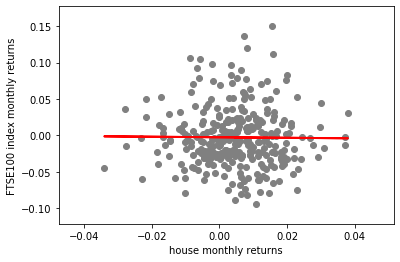

In [19]:
f_monthly = pd.read_excel('monthly.xls',sheet_name='Monthly')
f_ftse = pd.read_csv('FTSE100.csv')
house_date,house_price = f_monthly['Unnamed: 0'],f_monthly['Average House Price']
housepos = f_monthly.loc[f_monthly['Unnamed: 0'] == '2016-12-01'].index[0]
house_date,house_price = house_date[:housepos+1],house_price[:housepos+1]
ftse_date,ftse_index = f_ftse['Date'].astype('datetime64[ns]') ,f_ftse['Adj Close']
# FTSE monthly return
ftse_list = np.array(ftse_index)
house_list = np.array(house_price)
print(len(ftse_list),len(house_list))
ftse_mr,house_mr = get_monthly_retrun(ftse_list),get_monthly_retrun(house_list)

Y = ftse_mr.reshape(-1,1)  # Dependent variable
X = house_mr.reshape(-1,1) # Explanatory Variable
print(X.shape,Y.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X, Y) #training the algorithm
#To retrieve the intercept:
print("Interception: ",regressor.intercept_)
#For retrieving the slope:
print("Correlation Coefficient:",regressor.coef_)

y_pred = regressor.predict(X)
plt.scatter(X, Y,  color='gray')
plt.plot(X, y_pred, color='red', linewidth=2)
plt.xlabel("house monthly returns")
plt.ylabel("FTSE100 index monthly returns")
plt.show()


## Answer 1

### I. What do the result tell us

### II. Hypothsis to bakcup conclusion about existence of a signifcant relationship between these two variables

## Question 2

In [6]:
college_info = pd.read_csv('College.csv')
college_info.rename(columns={"Unnamed: 0":"Name"})
newdf = college_info[["Apps","Enroll","Outstate","Top10perc","Top25perc"]].copy()
print("********* Correlation coefficients of the variables *********")
print(newdf.corr()) # Correlation Coeficient

********* Correlation coefficients of the variables *********
               Apps    Enroll  Outstate  Top10perc  Top25perc
Apps       1.000000  0.846822  0.050159   0.338834   0.351640
Enroll     0.846822  1.000000 -0.155477   0.181294   0.226745
Outstate   0.050159 -0.155477  1.000000   0.562331   0.489394
Top10perc  0.338834  0.181294  0.562331   1.000000   0.891995
Top25perc  0.351640  0.226745  0.489394   0.891995   1.000000


In [7]:
# b) StepWise linear regression Model
# c) Which predictor variables are useful in predicting the graduation rate? Exxplain how you got those variables.
# d) Would the set of predictor variables be useful in predicting the graduation reate if you
#    werer to use BIC to select the model? Why?
# e) Compare the accurate of the model using only useful predictors with the one of the model using 
#    all five predictors?
# f) Given a set of predictor corresponding to CMU, what graduation rate value should the moset accurate model predict?



## Question 3

### Data Set

[City of Chicago Speed Camera Violations](https://catalog.data.gov/dataset/speed-camera-violations-997eb) from data.gov (from 2014-07-01 to 2019-09-24 ), the data points I'm choosing are the time records and number of speed violations recored by the camera for every corresponding time.

### My Assumption

The monthly average speed violations decreseas along with time.


### Methology

Algorithm used: Linear Regression

**Procedure**
1. Used data from 2014-07 to 2016-03 as the training dataset
2. Used the trained model to predict the speed violations from 2016-01 to 2019-07

### Conclusions

The trained model mostly corretly reflected the actual result, though for the time period from Janurary 2019 to July 2019, there is a highly non-linear flucturation of the speed violations, so fo that part the model didn't reflect the true result accurately

To sum up, my assumption holds true since the trend of monthly average speed violations for the city of Chicago decreased along with time.








0        2019-09-24
1        2019-09-24
2        2019-09-24
3        2019-09-24
4        2019-09-24
            ...    
201167   2014-07-01
201168   2014-07-01
201169   2014-07-01
201170   2014-07-01
201171   2014-07-01
Name: VIOLATION DATE, Length: 201172, dtype: datetime64[ns]


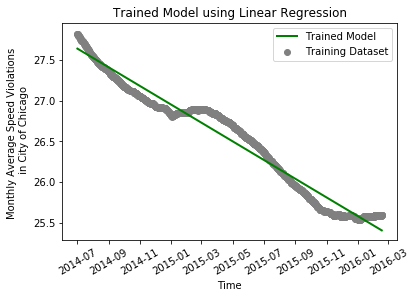

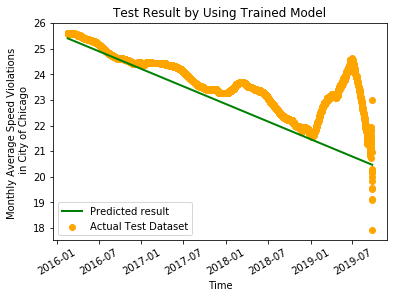

In [12]:
##### DATA INITIALIZATION #####
scvdf = pd.read_csv("Speed_Camera_Violations.csv")
scvdf["VIOLATION DATE"] = pd.to_datetime(scvdf["VIOLATION DATE"])
print(scvdf["VIOLATION DATE"])
violate_date = np.array(scvdf["VIOLATION DATE"].map(dt.datetime.toordinal)).reshape(-1,1)
violate_cnt = np.array(scvdf["VIOLATIONS"])
start = 0
violate_mean = []
adjusted_timestamp = []
adjusted_time = []
for i in range(30,len(violate_cnt),30):
    violate_mean.append(violate_cnt[start:i].mean())
    adjusted_timestamp.append(violate_date[i-30])
    adjusted_time.append(dt.datetime.fromordinal(violate_date[i-30]))
##### Split the portion for Training and Testing #####
TRAIN_PORTION = 1-0.3
train_len = int(len(violate_mean) * TRAIN_PORTION) # Set the portion for training
test_len = len(violate_mean) - train_len # The rest portion for testing
Y_train = violate_mean[train_len:]  
X_train = adjusted_timestamp[train_len:] 
Y_test = violate_mean[:train_len]  
X_test = adjusted_timestamp[:train_len]
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm
##### TRAIN #####
Y_pred = regressor.predict(X_train)
plt.scatter(X_train, Y_train,  color='gray',label="Training Dataset")
pred_date = [dt.datetime.fromordinal(i) for i in X_train]
train_date = [dt.datetime.fromordinal(i) for i in X_train]
plt.plot(train_date, Y_pred, color='green', linewidth=2,label="Trained Model")
plt.xlabel("Time")
plt.ylabel("Monthly Average Speed Violations \n in City of Chicago")
plt.xticks(rotation=30)
plt.title("Trained Model using Linear Regression")
plt.legend()
plt.show()
##### TEST #####
Y_pred = regressor.predict(X_test)
plt.scatter(X_test, Y_test,  color='orange',label='Actual Test Dataset')
pred_date = [dt.datetime.fromordinal(i) for i in X_test]
train_date = [dt.datetime.fromordinal(i) for i in X_train]
plt.plot(pred_date, Y_pred, color='green', linewidth=2, label="Predicted result")
plt.xlabel("Time")
plt.ylabel("Monthly Average Speed Violations \n in City of Chicago")
plt.title("Test Result by Using Trained Model")
plt.xticks(rotation=30)
plt.legend()
plt.show()



## Question 4

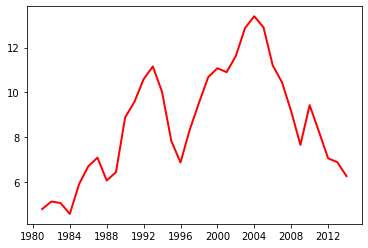

Interception:  [-221.25830864]
Correlation Coefficient: [[0.00031529]]


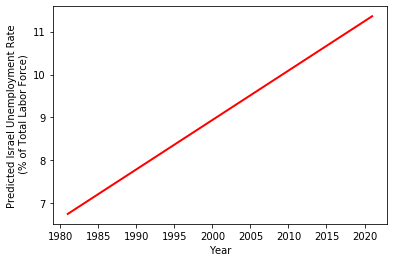

Predicted Unemployment Rate by year 2020: 2020-12-31 00:00:00 [11.35775739]
Actual Unemployment Rate by year 2020: 2020-12-31 00:00:00 3.9739999999999998


In [18]:

isr_lur = pd.read_csv("ODA-ISR_LUR.csv")
endpos = isr_lur.loc[isr_lur['Date'] == '2013-12-31'].index[0]
endpos_2020 = isr_lur.loc[isr_lur['Date'] == '2020-12-31'].index[0]
trueval_2020 = isr_lur['Value'][endpos_2020]
date_to_2020 = np.array(pd.to_datetime(isr_lur.tail(len(isr_lur)-endpos_2020)['Date']).map(dt.datetime.toordinal)).reshape(-1,1)
# print(date_to_2020)
isr_lur = isr_lur.tail(len(isr_lur)-endpos)
isr_lur['Date'] = pd.to_datetime(isr_lur['Date'])
isr_lur_val = np.array(isr_lur['Value'])

plt.plot(isr_lur['Date'], isr_lur_val, color='red', linewidth=2)
plt.show()
isr_lur_date = np.array(isr_lur['Date'].map(dt.datetime.toordinal))



X = isr_lur_date.reshape(-1,1)  # Dependent variable
Y = isr_lur_val.reshape(-1,1) # Explanatory Variable
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=0)
X_train, Y_train = X,Y

regressor = LinearRegression()  
# regressor = linear_model.Ridge(alpha=.1)
regressor.fit(X_train, Y_train) #training the algorithm
#To retrieve the intercept:
print("Interception: ",regressor.intercept_)
print("Correlation Coefficient:",regressor.coef_)
y_pred = regressor.predict(date_to_2020)
x_date = [dt.datetime.fromordinal(i) for i in date_to_2020]
plt.plot(x_date, y_pred, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Predicted Israel Unemployment Rate\n (% of Total Labor Force)")
plt.show()

print("Predicted Unemployment Rate by year 2020:",x_date[0],y_pred[0])
print("Actual Unemployment Rate by year 2020:",x_date[0],trueval_2020)
